# Lateness

- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pulp
import pandas as pd
pd.set_option('display.max_rows', 21)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.heuristics.fcfs as heuristics

import time

In [2]:
max_time = 60 * 60 * 5 # 5 h
max_time = 60 * 15 # 15 min

In [3]:
basic_data_path = get_path("data", "basic")
df_instance = pd.read_csv(basic_data_path / "00_instance.csv")

df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 1, u_b_mmax= 0.94, shuffle = True)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
315,Job_031,5,M1,28
316,Job_031,6,M6,46
317,Job_031,7,M5,46
318,Job_031,8,M7,72


In [4]:
df_jobs = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)
df_jobs

,Job,Arrival,Deadline
0,Job_000,0.00,1323.0
1,Job_001,81.32,1789.0
2,Job_002,101.67,2004.0
3,Job_003,142.01,2335.0
4,Job_004,177.21,1493.0
...,...,...,...
27,Job_027,1390.30,3195.0
28,Job_028,1391.02,2714.0
29,Job_029,1410.87,2727.0
30,Job_030,1423.44,2746.0


## a) Absolute Lateness Summe

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).



In [5]:

def solve_jssp_sum_absolute_lateness( df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, solver: str = 'HiGHS', 
                                     epsilon: float = 0.0, sort_ascending: bool = False,  **solver_args) -> pd.DataFrame:
    """
    Minimiert die Summe der absoluten Lateness (Früh- oder Spätfertigung) aller Jobs.
    Zielfunktion: sum_j [ |C_j - d_j| ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver: 'CBC' oder 'HiGHS' (case-insensitive).
    - epsilon: Pufferzeit zwischen Operationen auf derselben Maschine.
    - sort_ascending: Sortiert die Jobs nach Deadline.
    - **solver_args: Weitere Solver-Parameter wie msg=True, timeLimit=1200 etc.

    Rückgabe:
    - DataFrame mit ['Job','Operation','Arrival','Deadline','Machine',
      'Start','Processing Time','End','Lateness','Absolute Lateness'].
    """

    # 1. Vorverarbeitung
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # BigM berechnen
    sum_proc_time = df_jssp["Processing Time"].sum()
    min_arrival = min(arrival.values())
    max_deadline = max(deadline.values())
    num_machines = df_jssp["Machine"].nunique()
    
    bigM_raw = max_deadline - min_arrival + sum_proc_time / math.sqrt(num_machines)
    bigM = math.ceil(bigM_raw / 1000) * 1000
    print(f"BigM: {bigM}")

    # 2. Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = str(row["Machine"])
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)

    # 3. Modell
    prob = pulp.LpProblem("JSSP_SumAbsoluteLateness", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=arrival[jobs[j]])
        for j in range(n)
        for o in range(len(all_ops[j]))
    }

    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=arrival[jobs[j]])
        for j in range(n)
    }

    abs_lateness = {
        j: pulp.LpVariable(f"abs_lateness_{j}", lowBound=0)
        for j in range(n)
    }

    # Zielfunktion
    prob += pulp.lpSum(abs_lateness[j] for j in range(n))

    # 4. Technologische Reihenfolge & Lateness
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o in range(1, len(seq)):
            d_prev = seq[o - 1][2]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

        d_last = seq[-1][2]
        prob += ends[j] == starts[(j, len(seq) - 1)] + d_last

        # Absolute Lateness: max(±(End - Deadline))
        lateness = ends[j] - deadline[job]
        prob += abs_lateness[j] >= lateness
        prob += abs_lateness[j] >= -lateness

    # 5. Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i + 1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 6. Solverwahl
    solver_args.setdefault("msg", True)
    solver = solver.upper()
    if solver == "HIGHS":
        cmd = pulp.HiGHS_CMD(**solver_args)
    elif solver == "CBC":
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")

    prob.solve(cmd)
    objective_value = pulp.value(prob.objective)

    # 7. Ergebnis extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            lateness = round(ed - deadline[job], 2)
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": m,
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Lateness": lateness,
                "Absolute Lateness": abs(lateness)
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
        .sort_values(["Start", "Job", "Operation"])
        .reset_index(drop=True)
    )

    # 8. Logging
    print("\nSolver-Informationen:")
    print(f"  Summe Absolute Lateness : {round(objective_value, 4)}")
    print(f"  Solver-Status           : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen        : {len(prob.variables())}")
    print(f"  Anzahl Constraints      : {len(prob.constraints)}")

    return df_schedule


In [6]:
starting_time = time.time()

# Scheduling
df_plan_sum_l = solve_jssp_sum_absolute_lateness(df_jssp, df_jobs, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_l

BigM: 9000

Solver-Informationen:
  Summe Absolute Lateness : 6084.2
  Solver-Status           : Optimal
  Anzahl Variablen        : 5344
  Anzahl Constraints      : 10304

Scheduling-Dauer: 15 Minuten und 0.45 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_000,0,0.00,1323.0,M0,0.00,29.0,29.00,-1294.00,1294.00
1,Job_000,1,0.00,1323.0,M1,29.00,78.0,107.00,-1216.00,1216.00
2,Job_000,2,0.00,1323.0,M2,107.00,9.0,116.00,-1207.00,1207.00
3,Job_000,3,0.00,1323.0,M3,116.00,36.0,152.00,-1171.00,1171.00
4,Job_000,4,0.00,1323.0,M4,152.00,49.0,201.00,-1122.00,1122.00
...,...,...,...,...,...,...,...,...,...,...
315,Job_023,9,1211.51,3211.0,M8,3565.68,74.0,3639.68,428.68,428.68
316,Job_025,9,1252.14,3154.0,M4,3565.68,33.0,3598.68,444.68,444.68
317,Job_024,7,1238.36,3432.0,M3,3624.68,98.0,3722.68,290.68,290.68
318,Job_024,8,1238.36,3432.0,M9,3722.68,22.0,3744.68,312.68,312.68


In [7]:
show.count_column_grouped(df_plan_sum_l, 'Absolute Lateness')

label
0              4
0 - 60        31
60 - 120      25
120 - 180     18
>180         242
Name: count, dtype: int64

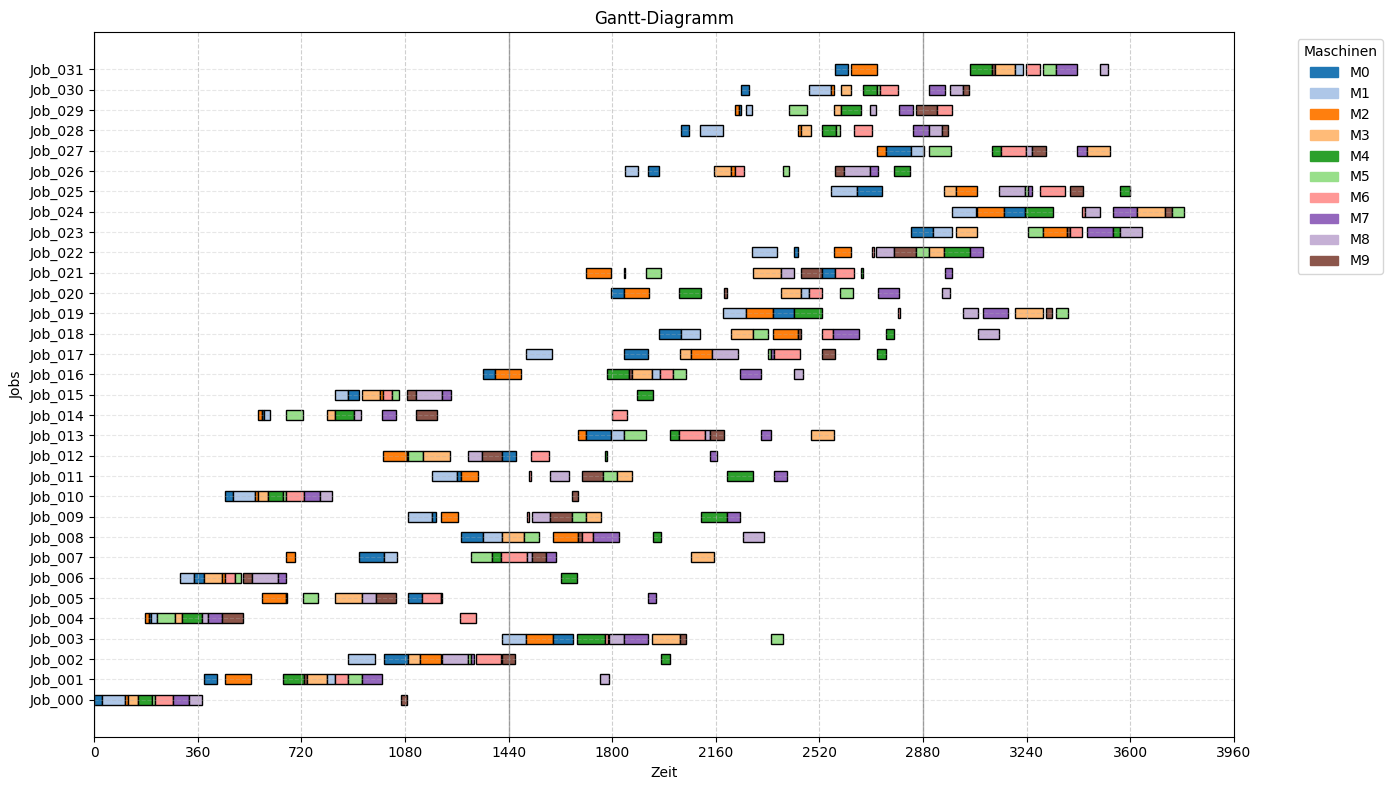

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [8]:
df_plan = df_plan_sum_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## b) größte absolute Lateness minimieren

$$
\min \; \max_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **größte Abweichung** eines Jobs zur Deadline – unabhängig davon, ob der Job **zu früh oder zu spät** fertiggestellt wurde.  
Sie sorgt dafür, dass **kein Job extrem abweicht**, und behandelt **Früh- und Spätfertigstellungen gleichwertig**.


In [9]:

def solve_jssp_max_absolute_lateness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, solver: str = 'HiGHS',
                                     epsilon: float = 0.0, sort_ascending: bool = False, **solver_args) -> pd.DataFrame:
    """
    Minimiert die maximale absolute Lateness (Früh- oder Spätfertigung) über alle Jobs.
    Zielfunktion: min max_j [ |C_j - d_j| ]

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals_deadlines: DataFrame mit ['Job','Arrival','Deadline'].
    - solver: 'CBC' oder 'HiGHS' (case-insensitive).
    - epsilon: Pufferzeit zwischen Jobs auf derselben Maschine.
    - sort_ascending: Sortiert nach Deadline.
    - **solver_args: Weitere Solver-Parameter (msg=True, timeLimit=1200 etc.)

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Deadline',
      'Machine','Start','Processing Time','End','Lateness','Absolute Lateness'].
    """

    # 1. Vorverarbeitung
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # BigM berechnen
    sum_proc_time = df_jssp["Processing Time"].sum()
    min_arrival = min(arrival.values())
    max_deadline = max(deadline.values())
    num_machines = df_jssp["Machine"].nunique()
    
    bigM_raw = max_deadline - min_arrival + sum_proc_time / math.sqrt(num_machines)
    bigM = math.ceil(bigM_raw / 1000) * 1000
    print(f"BigM: {bigM}")

    # 2. Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = row["Operation"]
            m = str(row["Machine"])
            d = float(row["Processing Time"])
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)

    # 3. LP-Modell
    prob = pulp.LpProblem("JSSP_MaxAbsLateness", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=arrival[jobs[j]])
        for j in range(n)
        for o in range(len(all_ops[j]))
    }

    ends = {
        j: pulp.LpVariable(f"end_{j}", lowBound=arrival[jobs[j]])
        for j in range(n)
    }

    abs_lateness = {
        j: pulp.LpVariable(f"abs_lateness_{j}", lowBound=0)
        for j in range(n)
    }

    max_abs_lateness = pulp.LpVariable("max_abs_lateness", lowBound=0)

    # Zielfunktion: minimiert die maximale absolute Lateness
    prob += max_abs_lateness

    # 4. Technologische Reihenfolge und Abweichungen
    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o in range(1, len(seq)):
            d_prev = seq[o - 1][2]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

        d_last = seq[-1][2]
        prob += ends[j] == starts[(j, len(seq) - 1)] + d_last

        lateness = ends[j] - deadline[job]
        prob += abs_lateness[j] >= lateness
        prob += abs_lateness[j] >= -lateness
        prob += max_abs_lateness >= abs_lateness[j]

    # 5. Maschinenkonflikte
    for m in machines:
        ops_on_m = [
            (j, o, seq[o][2])
            for j, seq in enumerate(all_ops)
            for o in range(len(seq))
            if seq[o][1] == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i + 1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 6. Solverwahl
    solver_args.setdefault("msg", True)
    solver = solver.upper()
    if solver == "HIGHS":
        cmd = pulp.HiGHS_CMD(**solver_args)
    elif solver == "CBC":
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")

    prob.solve(cmd)
    objective_value = pulp.value(prob.objective)

    # 7. Ergebnis extrahieren
    records = []
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            st = starts[(j, o)].varValue
            ed = st + d
            lateness = round(ed - deadline[job], 2)
            records.append({
                "Job": job,
                "Operation": op_id,
                "Arrival": arrival[job],
                "Deadline": deadline[job],
                "Machine": m,
                "Start": round(st, 2),
                "Processing Time": d,
                "End": round(ed, 2),
                "Lateness": lateness,
                "Absolute Lateness": abs(lateness)
            })

    df_schedule = (
        pd.DataFrame.from_records(records)
        .sort_values(["Start", "Job", "Operation"])
        .reset_index(drop=True)
    )

    # 8. Logging
    print("\nSolver-Informationen:")
    print(f"  Maximale absolute Lateness: {round(objective_value, 4)}")
    print(f"  Solver-Status             : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen          : {len(prob.variables())}")
    print(f"  Anzahl Constraints        : {len(prob.constraints)}")

    return df_schedule


In [10]:
starting_time = time.time()

# Scheduling
df_plan_max_l = solve_jssp_max_absolute_lateness(df_jssp, df_jobs, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_max_l

BigM: 9000

Solver-Informationen:
  Maximale absolute Lateness: 208.41
  Solver-Status             : Optimal
  Anzahl Variablen          : 5345
  Anzahl Constraints        : 10336

Scheduling-Dauer: 15 Minuten und 1.08 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_000,0,0.00,1323.0,M0,0.00,29.0,29.00,-1294.00,1294.00
1,Job_000,1,0.00,1323.0,M1,29.00,78.0,107.00,-1216.00,1216.00
2,Job_000,2,0.00,1323.0,M2,107.00,9.0,116.00,-1207.00,1207.00
3,Job_000,3,0.00,1323.0,M3,116.00,36.0,152.00,-1171.00,1171.00
4,Job_000,4,0.00,1323.0,M4,152.00,49.0,201.00,-1122.00,1122.00
...,...,...,...,...,...,...,...,...,...,...
315,Job_023,9,1211.51,3211.0,M8,3345.41,74.0,3419.41,208.41,208.41
316,Job_024,6,1238.36,3432.0,M7,3345.41,85.0,3430.41,-1.59,1.59
317,Job_024,7,1238.36,3432.0,M3,3430.41,98.0,3528.41,96.41,96.41
318,Job_024,8,1238.36,3432.0,M9,3528.41,22.0,3550.41,118.41,118.41


In [11]:
show.count_column_grouped(df_plan_max_l, 'Absolute Lateness')

label
0              4
0 - 60        23
60 - 120      26
120 - 180     31
>180         236
Name: count, dtype: int64

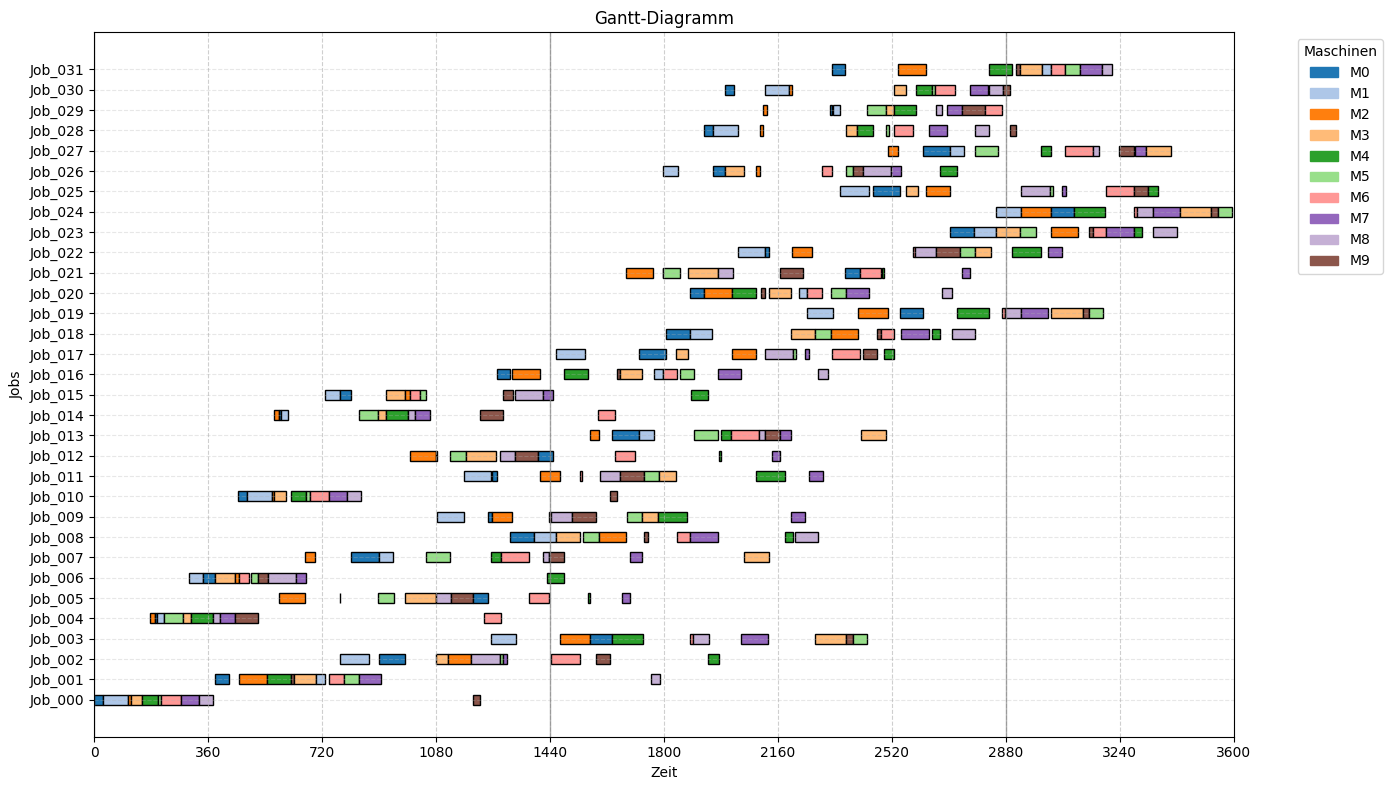

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [12]:
df_plan = df_plan_max_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)